# CM2015 Programming with Data 
# Midterm Project 

## Introduction 
The project will scrape data from https://hilites.today/. Hilites.today is a website that scrapes data about immigration cases status from https://www.uscis.gov/, the official website of U.S. Citizenship and Immigration Services (USCIS) and summarizes approved cases date by date. 
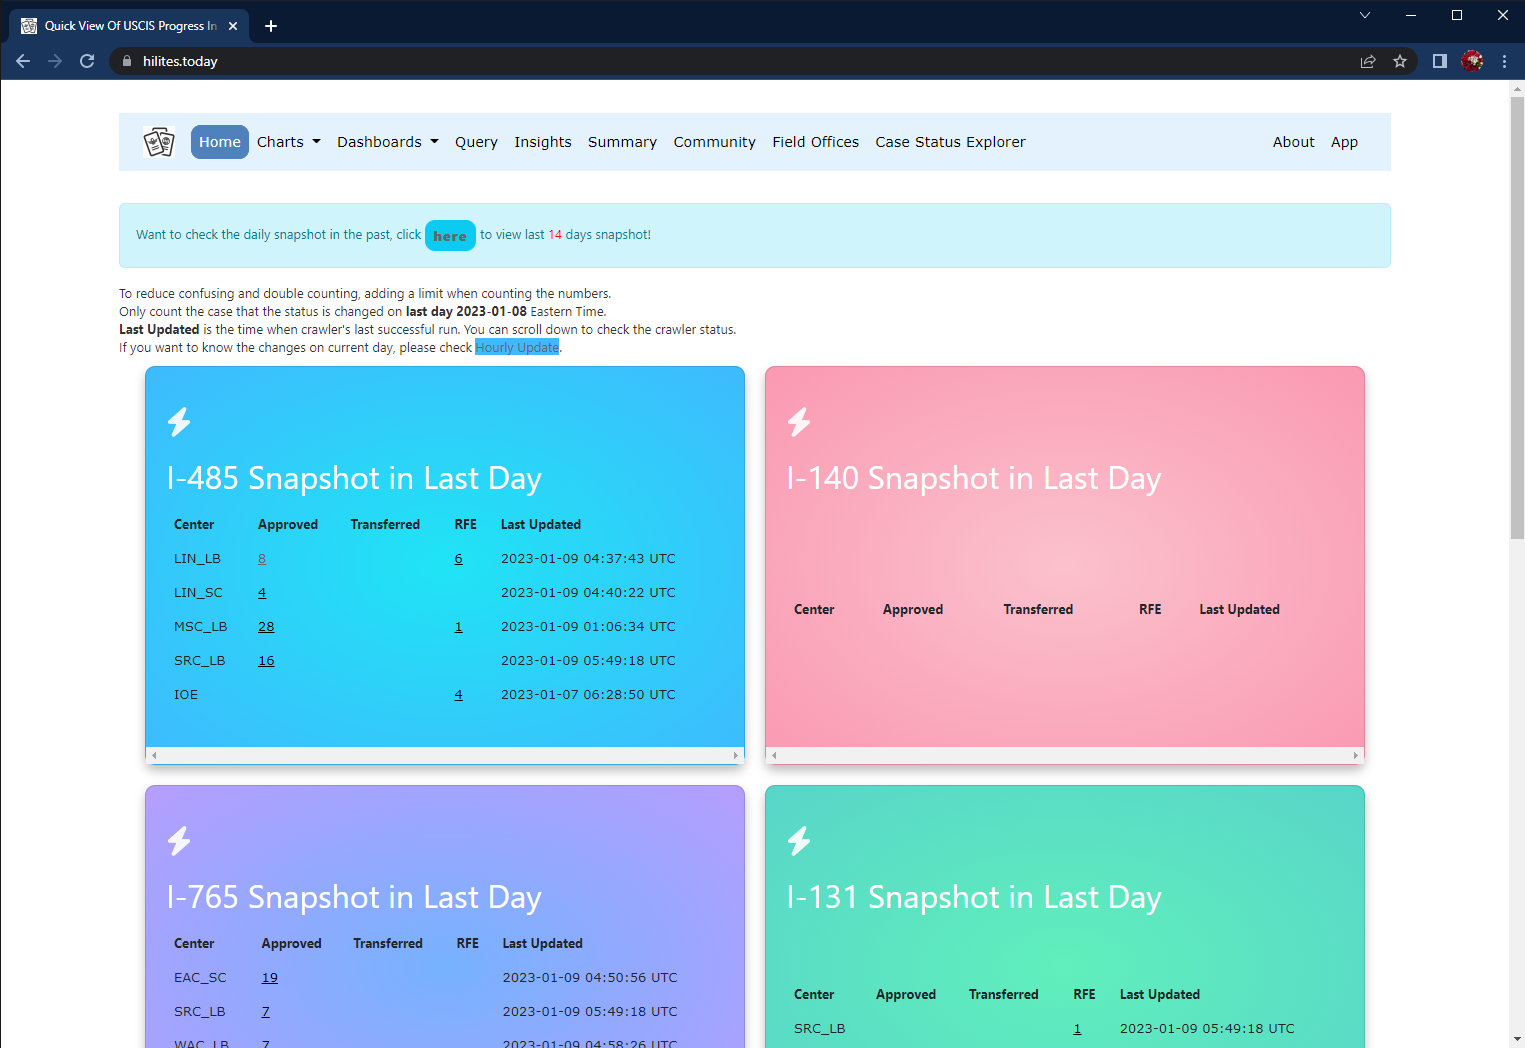

## Project Background and Aims 
During the pandemic COVID-19, there was a backlog in processing applications in USCIS system, thousands of applicants worried about status of their cases, hence, causing overwhelming in enquiry services such as live chat or customer hotline. Unfortunately, it worsened the situation since USCIS had been lacking human resources for years, and so cases were being delayed and immigrants in the U.S. kept worry about their fate. 
To help bringing down the shattering and easing the applicants, this project aims to collect data about processing time of approved cases to give people idea about ongoing normal processing time, and so they should only make an enquiry when their cases are out of the range. 

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

import urllib3
from bs4 import *

import urllib.parse
from urllib.parse import urljoin
from urllib.parse import urlparse

import json
import time

import datetime
from datetime import datetime, timedelta

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a programmable browser
s = Service("C:/Users/Api Rich/Desktop/installer/chromedriver.exe")
driver = webdriver.Chrome(service = s)

## Data Acquisition 
The program will get the page of the passing URL, navigate to elements that contains in their text: name of a USCIS service center, LIN in this case, and the current latest approved date. It grabs the date and joins it in the default URL to generate a new default URL that will be used to concatenate with the date to generate another URL of a page that displays a list of approved cases of the date. 

In [ ]:
# Generate URL for the lastest date list of approved cases
def getPage(paURL):
    url = paURL

    http = urllib3.PoolManager()
    response = http.request("GET", url)

    try:
        soup = BeautifulSoup(response.data, "html.parser")

        # Current date (today date)
        todayDate = soup.find("input", {"class": "form-control"})

        # Navigate to LIN_LB
        linLB = soup.find("td", text = "LIN_LB")

        # Join path to get URL of approved cases from LIN_LB
        linLBnextSib = linLB.find_next_sibling("td")
        linLBhref = linLBnextSib.next["href"]
        
        resultURL = urljoin("https://hilites.today/", linLBhref)

        return resultURL, datetime.strptime(todayDate["value"], "%Y-%m-%d").date()
    except:
        print("getPage(): Could not load page or target elements have changed!")
        print(response.data)

In [ ]:
# Call getPage() and passed the return value to global variables        
try:
    driverURL, currentDate = getPage("https://hilites.today/snapshot/history")
except:
    print("Could not assign value to driverURL, and currentDate!")

In [ ]:
# Get URL for each single date
def getDateURL(paDriURL, paCurDate):
    try:
        params = {"lad": paCurDate}
        
        URL = urlparse(paDriURL)
        query = dict(urllib.parse.parse_qsl(URL.query))
        query.update(params)

        dateURL = URL._replace(query = urllib.parse.urlencode(query)).geturl()

        return dateURL
    except:
        print("getDateURL(): Could not generate URL!")

The next step, the program will navigate to the page, find the element to get list of case numbers, write it in a custom data structure and dump it in a just created .json file (in the current working directory). It will be looping to get data of the current latest week (the last seven days). 

Example of the custom data structure before “SubDate” has been updated: 
[{"ID": "1", "Case": "LIN2190064537", "Date": "2022-12-23", "SubDate": ""}] 

In [ ]:
# Cases list to dict, then write to a json file
def writeJSON(data, date):
    try:
        d = [{"ID" : str(i + 1), "Case" : data[i].text, "Date" : str(date), "SubDate" : ""} for i in range(len(data))]
        with open(str(date) + ".json", "w", encoding = "utf-8") as f:
            json.dump(d, f, ensure_ascii=False)
            f.close()
    except:
        print("writeJSON(): Couldn't write json files!")

In [ ]:
# Go to cases detail in the last 7 days
currentDatePage = 1
maxPages = 7

try:
    while currentDatePage <= maxPages:
        time.sleep(3)

        driver.get(getDateURL(driverURL, currentDate))

        cases = driver.find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "a")
        writeJSON(cases, currentDate)

        currentDate -= timedelta(days = 1)

        currentDatePage += 1
except:
    print("Could not load Cases Detail page!")

After that, the program will loop through all the available files, navigate to “Insights” page to get details (the applied date and processing days) of each single case and update the value of “SubDate” key in the .json files (files has to be in the current working directory). 

Example of the custom data structure after “SubDate” has been updated: 
[{"ID": "1", "Case": "LIN2190064537", "Date": "2022-12-23", "SubDate": "2021-03-31 639 days ago"}] 

In [ ]:
# Navigate to case input, set case number as value, and click Get Insights button to submit
def getCaseInsightPage(paURL, caseNum):
    driver.get(paURL)
    try:
        caseInput = driver.find_element(By.CLASS_NAME, "form-control")
        script = "arguments[0].value = '{}'".format(caseNum)
        driver.execute_script(script, caseInput)
        # driver.execute_script("arguments[0].value = caseNum;", caseInput)

        getInsightsBut = driver.find_element(By.NAME, "button").click()
        time.sleep(20)
    except:
        print("getCaseInsightPage(): Page load too slow or blocked!")

    try:
        insightDetail = driver.find_element(By.CLASS_NAME, "tracking-date")
        return insightDetail.text
    except:
        print("getCaseInsightPage(): Page after submit load too slow!")
        return "loadPageError"

In [ ]:
# Check if a filename is exist, if yes append SubDate, if not create it with new data
def adjustJSON(file, i, submission):
    try:
        with open(file, "r", encoding = "utf-8") as fJson:
            feeds = json.load(fJson)
            feeds[i]["SubDate"] = submission
            fJson.close()
        with open(file, "w", encoding = "utf-8") as fJson:
            json.dump(feeds, fJson)
            fJson.close()
    except:
        print("adjustJSON(): Couldn't adjust json files!")

In [ ]:
# Function to plot graph per file (per approval date)
def plotGraphs(file):
    try:
        df = pd.read_json(file)   

        # Split "SubDate" or throw error if "SubDate" wasn't successfully updated in adjustJSON()
        try:
            dfSplit = df["SubDate"].str.split(" ", n = 2, expand = True)
        except:
            print("plotGraphs(): Couldn't split SubDate!")

        df["Processing Days"] = dfSplit[1]
        df["SubDate"] = dfSplit[0]
        
        # Can use the line below to convert string (as a value in pandas dataframe) to datetime         
        # pd.to_datetime(df["SubDate"])

        dfSplit = df["Case"].str.split("N", n = 1, expand = True)
        df["Center"] = dfSplit[0] + "N"
        df["Case"] = dfSplit[1]

        dpd = df.sort_values(by = "Processing Days", ignore_index = True)
        
        # Print data in console if need (for debugging only!)         
        # print("Original data - sort by Case")
        # print(df)
        # print("Data sort by Processing Dates")
        # print(dpd)

        sizes = []
        for i in range(len(df.index)):
            sizes.append(int(df["Processing Days"][i]))

        dvSizes = []
        for i in range(len(dpd.index)):
            dvSizes.append(int(dpd["Case"][i]) / 10000000 + 8 * i)
    except:
        print("plotGraphs(): Couldn't read and process .json files after adjustJSON!")
    
    try:
        fig = plt.figure(figsize = (18, 10))
        plt.suptitle(file)

        plt.subplot(121)
        plt.scatter(df["Case"], df["Processing Days"], s = sizes, color = "green", alpha = 0.5)
        plt.title("Sort By Case")
        plt.xlabel("Case")
        plt.ylabel("Processing Days")

        plt.subplot(122)
        plt.scatter(dpd["Case"], dpd["Processing Days"], s = dvSizes, alpha = 0.5)
        plt.title("Sort by Processing Days")
        plt.xlabel("Case")
        plt.ylabel("Processing Days")

        plt.show()

        return sizes
    except:
        print("plotGraphs(): Couldn't plot scatter!")

In [ ]:
# List to store processing days of all cases (in order to calculate mean and SD)
arrProcDays = []

# Call adjustJSON(), passing getCaseInsightPage() to update "SubDate" for all cases
for file in reversed(os.listdir()):
    if file.endswith(".json"):
        try:
            df = pd.read_json(file)
            for i in df.index:
                adjustJSON(file, i, getCaseInsightPage("https://hilites.today/uscis_cases/insights", df["Case"][i]))
        except:
            print("Couldn't read .json files!")
        
        try:
            arrProcDays = arrProcDays + plotGraphs(file)
        except:
            print("Couldn't concatenate arrProcsDays!")

Finally, the program goes through all the files to plot scatter graphs for each file as well as add all values of processing days of all cases in the list for the purpose of calculating mean and standard deviation. 

In [ ]:
# Calculate mean and SD of all available cases
def meanAndSD(npArrProcDays):
    npArrProcDaysMean = np.mean(npArrProcDays)
    print("Mean", npArrProcDaysMean)

    sd = np.std(npArrProcDays)
    print("SD", sd)

In [ ]:
# Call meanAndSD()
try:
    meanAndSD(np.array(arrProcDays))
except:
    print("Couldn't pass arrProcDays to meanAndSD()!")

## Data Cleansing 
Since the program only scrapes for target data and passes it in a custom data structure, the data itself is clean and doesn’t require to be rigorously processed. 
However, when the current latest approved date (“Date”) is grabbed, it must be converted to datetime type to be used with timedelta to subtract the date by one day in the looping that mentioned in the second step in Data Acquisition. 
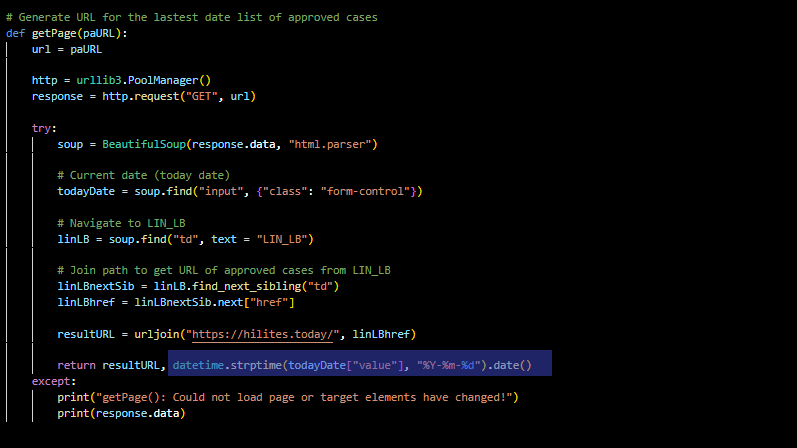

Additionally, “SubDate” also must be split to obtain processing days value only (for instance, grab “639”, and eliminate “days ago”). 
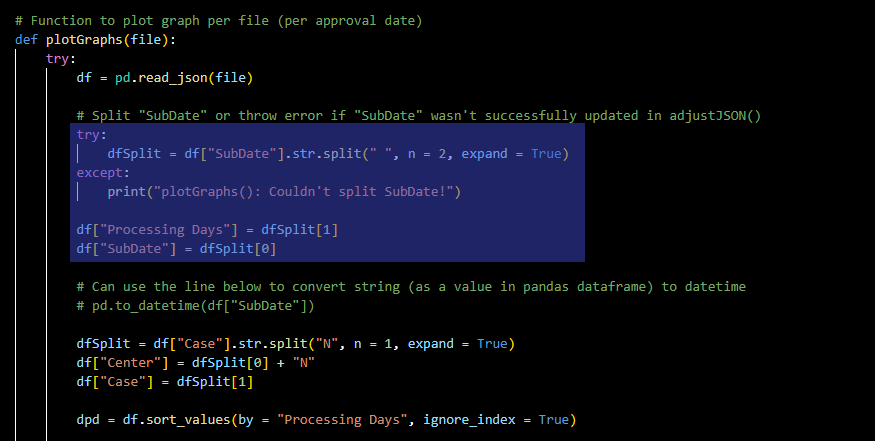

Meanwhile, “Case” is also split to subtract the initial LIN to sort data by case number for instance, grab “2190064537”, and eliminate “LIN”). 
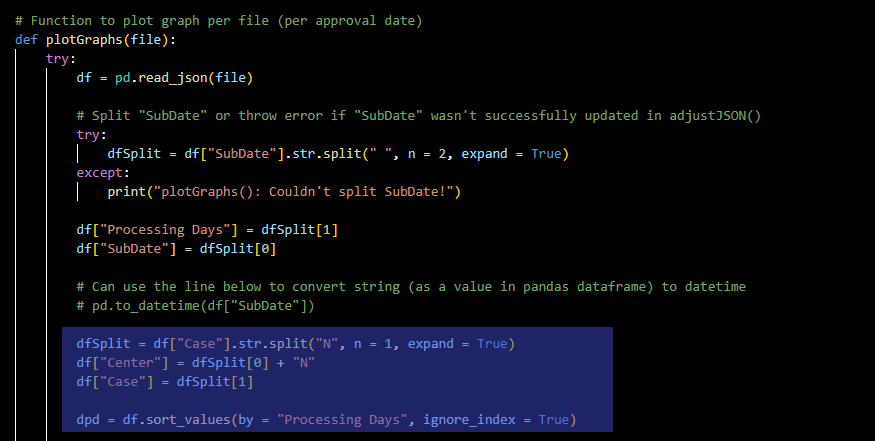

*** JSON files has to be in the current working directory!

## Analysis 
Case numbers from the scraping data has patterns of LIN21xxxxxxxx and LIN22xxxxxxxx. LIN is the initial for the USCIS service center in Lincoln, Nebraska, 21 is the year of 2021 when an application was submitted, and 22 is the year of 2022 when an application was submitted. The xxxxxxxx is indicated different categories of visas and real number of a case, this part will not be discussed in this project, and may be analyzed deeper in the final project along with processing time between steps since applying until being approved. 
After going through two sets of data: one from 2022-12-23 to 2022-12-30 and one from 2022-12-31 to 2023-01-07, plotting data in graphs showing that LIN22 cases are usually approved between 120 days (about 4 months) to 450 days (about 1 year 3 months) while LIN21 cases are slowly approved between 500 days (about 1 and a half years) to 700 days (about 2 years).  Additionally, on holidays and weekends the number of cases that are approved is much lesser than weekdays.
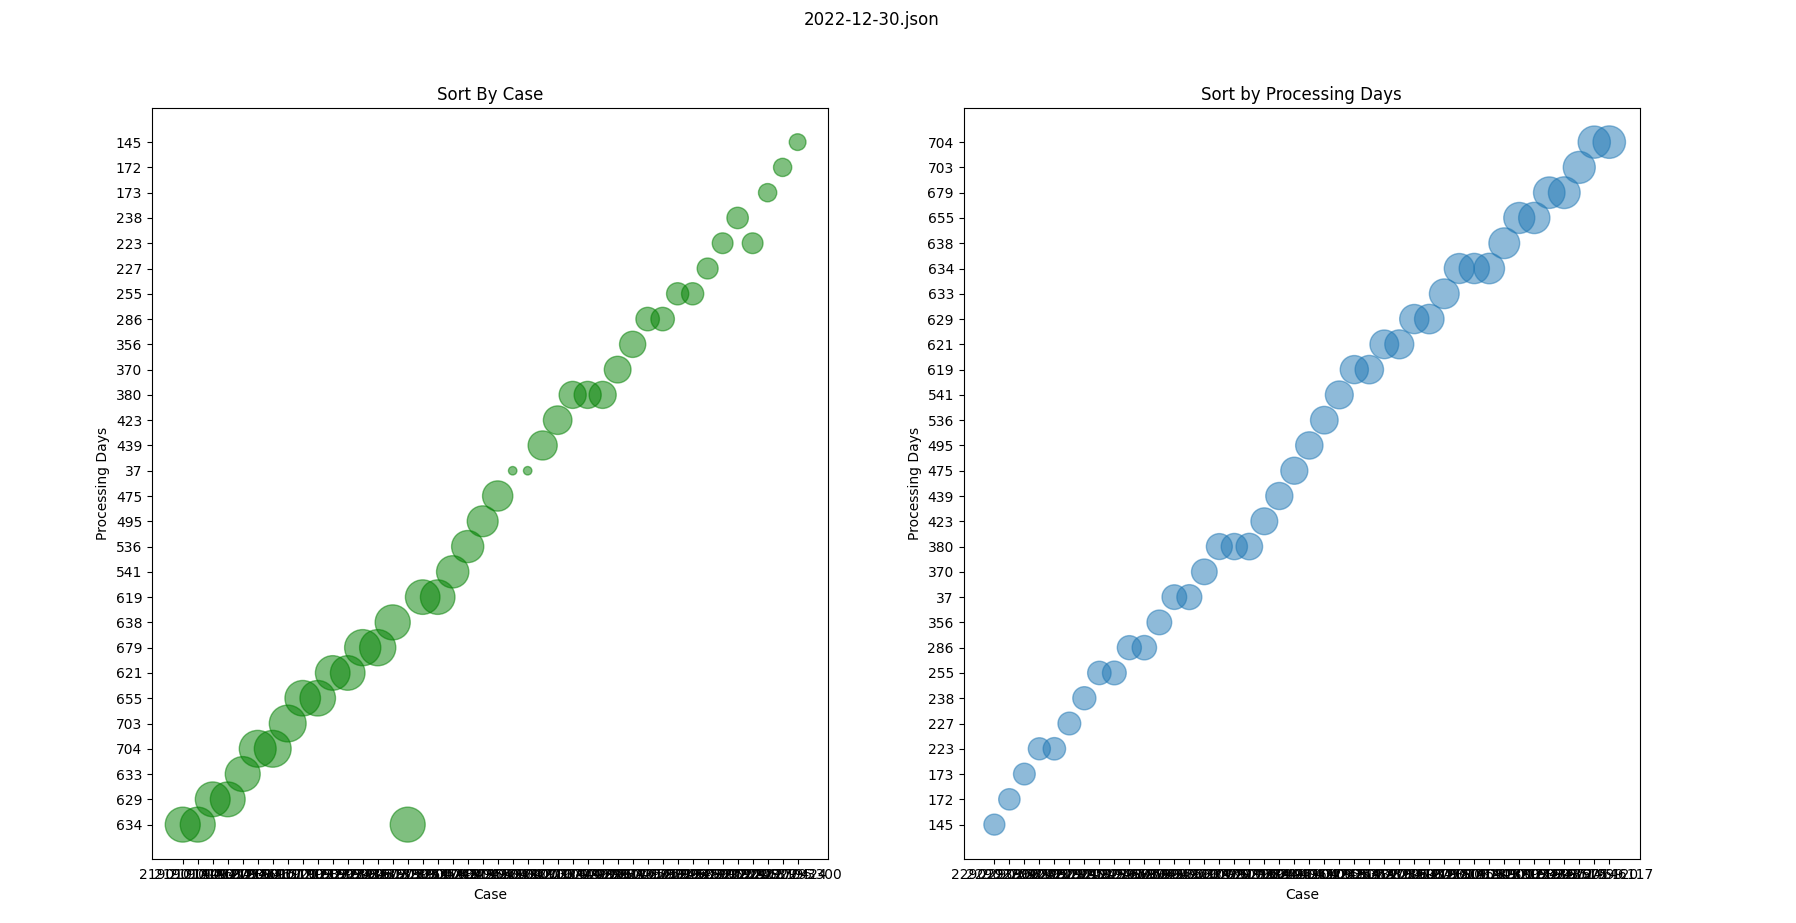

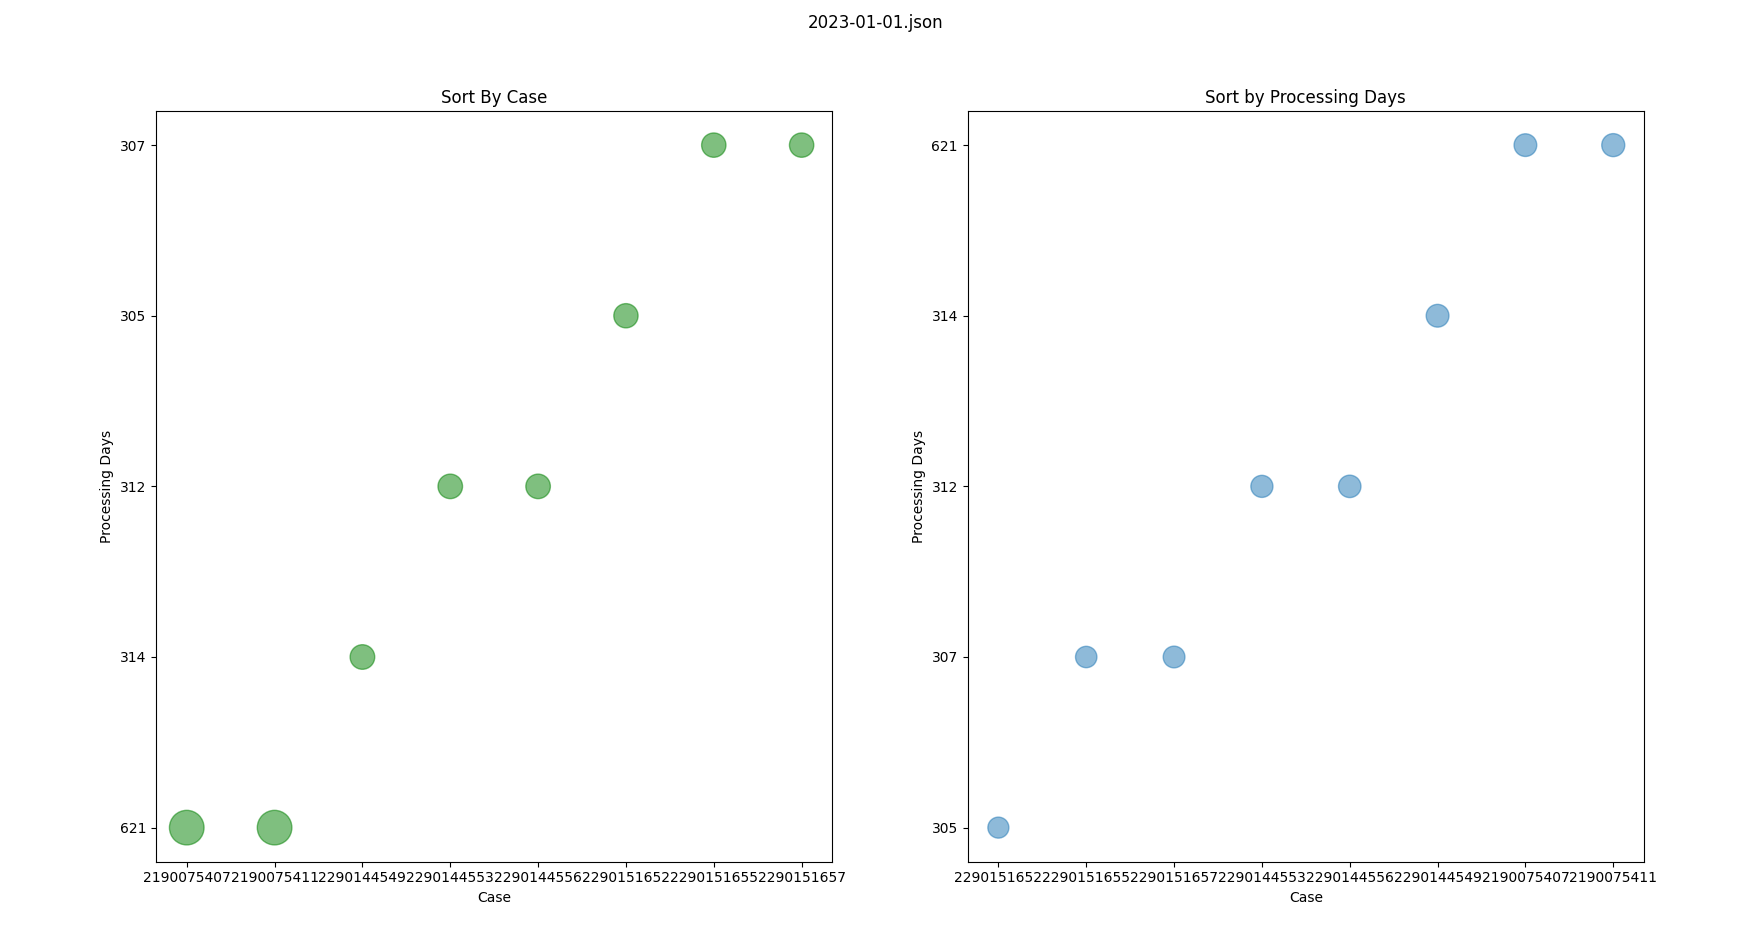
The difference is more than double, and it seems not fair at all. Nevertheless, as mentioned above, USCIS is experiencing COVID-19 backlog in their service, and so it is sensible that USCIS simultaneously processes both LIN21 and LIN22. Otherwise, if they just focused on LIN21 cases first, it would cause another backlog and the system would be corrupted. 

## Conclusion and Critical Evaluation 
Given the above, USCIS should improve their human resources, maybe establish an intensive team that completely works on backlog cases, which of course also requires a stable budget. 
In the meantime, applicants can use this program to check for the normal processing time (mean) and normally give or take within the range of the standard deviation and should only make an enquiry when your case is out of normal processing time. This way, USCIS will be able to manage their resources better, and work on your case faster. 

## Ethical statement 
Data from USCIS as well as hilites.today is public data, and so it has no ethical issues or causes any personal effects to scrape.  
In fact, it benefits the people, providing them with a better understanding about their application as well as verifying the efficiency workflow of a public service. 